In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

In [3]:
# Helper Function - heatmap
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current Axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(range(data.shape[1]), labels=col_labels,
                  rotation=-30, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Turn spines off and create white grid.
    #ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [4]:
# Parse Explorer Summary (NEW)
def parse_explorer_summary(explorer_data):
    with open(explorer_data, 'r') as f:
        data = [line.strip().split(',') for line in f.readlines()]

    for row in data:
        if '~' in row[0]:
            shift_ms = row[0].split('~')[1][:-4]
            days = int(shift_ms.split('-')[0])
            hours = int(shift_ms.split('-')[1])
            shift_h = (days * 24) + hours
            row[0] = shift_h
        else:
            row[0] = 0

    data_d = {}

    for row in data:
        data_d[row[0]] = {'emissions': row[1]}

    return data_d


def get_minimum(data):
    minimum = float(data[0]['emissions'])
    shift = 0

    for key, entry in data.items():
        if float(entry['emissions']) < minimum:
            minimum = float(entry['emissions'])
            shift = key

    return (shift, minimum)


def get_reduction(original, new):
    orig = float(original)
    neww = float(new)
    return ((orig - neww) / abs(orig)) * 100


def overview(trace, print=False):
    data = parse_explorer_summary(trace)
    (min_shift, min_emissions) = get_minimum(data)

    if print:
        print(f"Original [0] CCF {data[0]['emissions']} gCO2e")  # original
        print(f"Minimum [{min_shift}] CCF {min_emissions} gCO2e")  # minimum
        print(f"Reduction {get_reduction(data[0]['emissions'], min_emissions):.2f}%")

    return (data, min_shift, min_emissions)


def average(one, two, three):
    return (float(one) + float(two) + float(three)) / 3

In [5]:
# Constants
regions = ['Great Britain', 'Germany', 'California', 'Texas', 'South Africa', 'Tokyo', 'New South Wales']
short_regions = ['gb', 'de', 'ca', 'tx', 'zaf', 'tyo', 'nsw']
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
short_months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'] 
month_dates = ['08012024-13012024', '12022024-17022024', '11032024-16032024',  
    '08042024-13042024', '13052024-18052024', '10062024-15062024',  
    '08072024-13072024', '12082024-17082024', '09092024-14092024',  
    '14102024-19102024', '11112024-16112024', '09122024-14122024']
region_folders = [f'../data/results/entire-wf-shifting/out/{region}/' for region in short_regions]
workflows=['chipseq', 'mag', 'montage', 'nanoseq', 'rangeland', 'rnaseq', 'sarek']

In [9]:
# Parse Readings from files (!)
window = 24

for folder, region in zip(region_folders, short_regions):
    for i in range(0, 12):
        for workflow in workflows:
            path_one = f'{folder}explorer-{window}h-{workflow}-{short_months[i]}-1-{region}-{month_dates[i]}~footprint.csv'
            path_two = f'{folder}explorer-{window}h-{workflow}-{short_months[i]}-2-{region}-{month_dates[i]}~footprint.csv'
            path_three = f'{folder}explorer-{window}h-{workflow}-{short_months[i]}-3-{region}-{month_dates[i]}~footprint.csv'

            (data_1, min_shift_1, min_emissions_1) = overview(path_one)
            (data_2, min_shift_2, min_emissions_2) = overview(path_two)
            (data_3, min_shift_3, min_emissions_3) = overview(path_three)
            avg_orig_ems = average(data_1[0]['emissions'], data_2[0]['emissions'], data_3[0]['emissions'])
            avg_min_ems = average(min_emissions_1, min_emissions_2, min_emissions_3)
            avg_reduction = get_reduction(avg_orig_ems, avg_min_ems)
            print(f'{region} {months[i]} {workflow} done')

gb January chipseq done
gb January mag done
gb January montage done
gb January nanoseq done
gb January rangeland done
gb January rnaseq done
gb January sarek done
gb February chipseq done
gb February mag done
gb February montage done
gb February nanoseq done
gb February rangeland done
gb February rnaseq done
gb February sarek done
gb March chipseq done
gb March mag done
gb March montage done
gb March nanoseq done
gb March rangeland done
gb March rnaseq done
gb March sarek done
gb April chipseq done
gb April mag done
gb April montage done
gb April nanoseq done
gb April rangeland done
gb April rnaseq done
gb April sarek done
gb May chipseq done
gb May mag done
gb May montage done
gb May nanoseq done
gb May rangeland done
gb May rnaseq done
gb May sarek done
gb June chipseq done
gb June mag done
gb June montage done
gb June nanoseq done
gb June rangeland done
gb June rnaseq done
gb June sarek done
gb July chipseq done
gb July mag done
gb July montage done
gb July nanoseq done
gb July rang

In [13]:
# Parse Readings from files (!)
window = 96

for folder, region in zip(region_folders, short_regions):
    for i in range(0, 12):
        for workflow in workflows:
            path_one = f'{folder}explorer-{window}h-{workflow}-{short_months[i]}-1-{region}-{month_dates[i]}~footprint.csv'
            path_two = f'{folder}explorer-{window}h-{workflow}-{short_months[i]}-2-{region}-{month_dates[i]}~footprint.csv'
            path_three = f'{folder}explorer-{window}h-{workflow}-{short_months[i]}-3-{region}-{month_dates[i]}~footprint.csv'

            (data_1, min_shift_1, min_emissions_1) = overview(path_one)
            (data_2, min_shift_2, min_emissions_2) = overview(path_two)
            (data_3, min_shift_3, min_emissions_3) = overview(path_three)
            avg_orig_ems = average(data_1[0]['emissions'], data_2[0]['emissions'], data_3[0]['emissions'])
            avg_min_ems = average(min_emissions_1, min_emissions_2, min_emissions_3)
            avg_reduction = get_reduction(avg_orig_ems, avg_min_ems)
            print(f'{region} {months[i]} {workflow} done')

gb January chipseq done
gb January mag done
gb January montage done
gb January nanoseq done
gb January rangeland done
gb January rnaseq done
gb January sarek done
gb February chipseq done
gb February mag done
gb February montage done
gb February nanoseq done
gb February rangeland done
gb February rnaseq done
gb February sarek done
gb March chipseq done
gb March mag done
gb March montage done
gb March nanoseq done
gb March rangeland done
gb March rnaseq done
gb March sarek done
gb April chipseq done
gb April mag done
gb April montage done
gb April nanoseq done
gb April rangeland done
gb April rnaseq done
gb April sarek done
gb May chipseq done
gb May mag done
gb May montage done
gb May nanoseq done
gb May rangeland done
gb May rnaseq done
gb May sarek done
gb June chipseq done
gb June mag done
gb June montage done
gb June nanoseq done
gb June rangeland done
gb June rnaseq done
gb June sarek done
gb July chipseq done
gb July mag done
gb July montage done
gb July nanoseq done
gb July rang

entire workflow shifting (average CI)


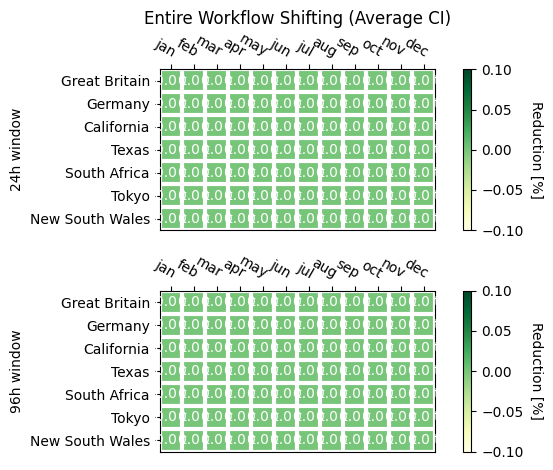

In [29]:
print('entire workflow shifting (average CI)')

# carbon footprint reductions
cf_reduction = np.array([[0] * 12] * 7)

fig, ax = plt.subplots(2)

# 24h window
im_24h, cbar_24h = heatmap(cf_reduction, regions, short_months, ax=ax[0],
                   cmap="YlGn", cbarlabel="Reduction [%]")
texts_24h = annotate_heatmap(im_24h, valfmt="{x:.1f} t")
ax[0].set_ylabel('24h window')

# 96h window
im_96h, cbar_96h = heatmap(cf_reduction, regions, short_months, ax=ax[1],
                   cmap="YlGn", cbarlabel="Reduction [%]")
texts_96h = annotate_heatmap(im_96h, valfmt="{x:.1f} t")
ax[1].set_ylabel('96h window')

ax[0].set_title('Entire Workflow Shifting (Average CI)')
fig.tight_layout()
plt.show()

entire workflow shifting (marginal CI)


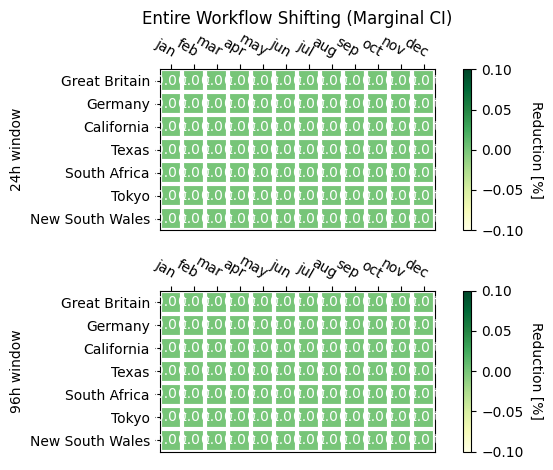

In [30]:
print('entire workflow shifting (marginal CI)')

# carbon footprint reductions
cf_reduction = np.array([[0] * 12] * 7)

fig, ax = plt.subplots(2)

# 24h window
im_24h, cbar_24h = heatmap(cf_reduction, regions, short_months, ax=ax[0],
                   cmap="YlGn", cbarlabel="Reduction [%]")
texts_24h = annotate_heatmap(im_24h, valfmt="{x:.1f} t")
ax[0].set_ylabel('24h window')

# 96h window
im_96h, cbar_96h = heatmap(cf_reduction, regions, short_months, ax=ax[1],
                   cmap="YlGn", cbarlabel="Reduction [%]")
texts_96h = annotate_heatmap(im_96h, valfmt="{x:.1f} t")
ax[1].set_ylabel('96h window')

ax[0].set_title('Entire Workflow Shifting (Marginal CI)')
fig.tight_layout()
plt.show()